In [46]:
__file__ = 'A1.ipynb'
import sys
import pathlib
sys.path.append(str(pathlib.Path(__file__).absolute().parent.parent)+"/FP4_lib")
import functions as f
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from uncertainties import unumpy as up
from uncertainties import ufloat
import scipy.constants as const
import scipy.fft as fft

In [47]:
with open('Data/Aufg_6.2.txt','r') as tf:
    data = np.genfromtxt(tf).T
with open('Res/cp-cal_res.txt','r') as tf:
    cal = np.genfromtxt(tf).T

data = f.channel_to_pos(data,cal)

von 3.8  
bis 4.55

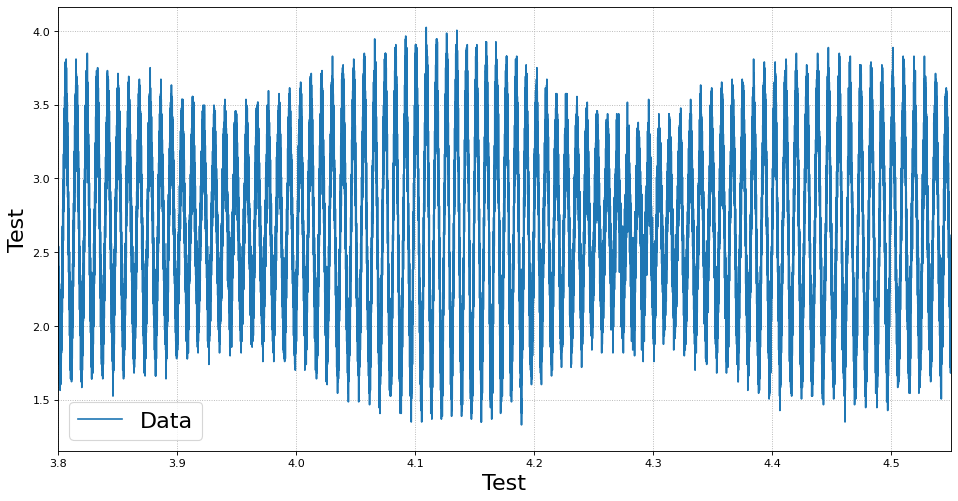

In [48]:
f.figsize(2)
plt.errorbar(data[0],data[1],label = 'Data')
f.form([3.8,4.55])

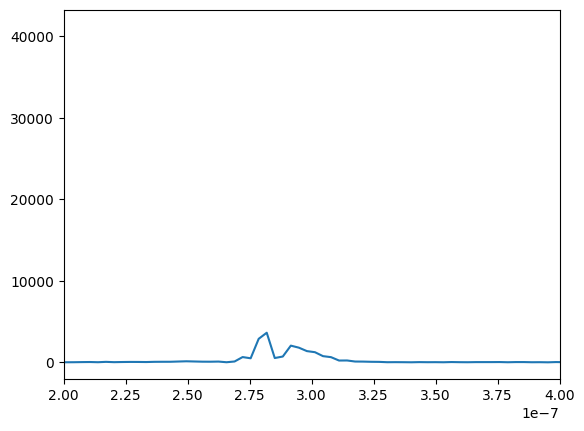

In [49]:
sr = 0.5/(f.pos(data[0],4.5)-f.pos(data[0],4.0))
n = len(data[1])
d = 1/sr
f = data[0]


yf = fft.rfft(data[1])
xs = fft.rfftfreq(n=n,d=d)
plt.xlim(0.2e-6,0.4e-6)
plt.plot(xs,np.abs(yf))

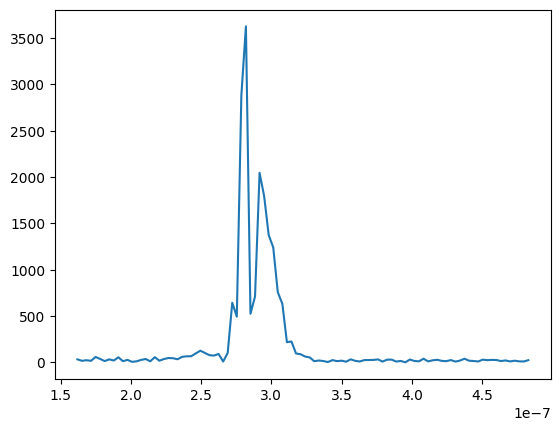

In [50]:
von,bis = 50,150
plt.plot(xs[von:bis],np.abs(yf)[von:bis])